<a href="https://colab.research.google.com/github/katemartian/LHoutputsManuscript/blob/master/LHoutputs_eYFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> LHA-eYFP All tests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/!lab/Manuscripts/LHoutputs/rawdata/

/content/drive/MyDrive/!lab/Manuscripts/LHoutputs/rawdata


In [ ]:
%run FiberPhotometryDataAnalysis_elife.ipynb

All Fiber Photometry functions are ready to use


In [ ]:
mice = ['LHA62','LHA63']
outputs = ['LHA-LHb','LHA-VTA','LHA-DRN']
tests = ['APT','SCT','OFT','TST']

In [ ]:
filename = 'LH-eYFP.h5'

# Save recordings to HDF file

In [ ]:
folders = {'APT': ['/content/drive/MyDrive/!lab/!FP/2019-06-17 LHA-7s-eYFP Airpuff/raw/',
                   '/content/drive/MyDrive/!lab/!FP/2019-07-09 LHA-6s-7s-eYFP Airpuff2/raw/'],
           'SCT': ['/content/drive/MyDrive/!lab/!FP/2019-06-26_to_07-03 LHA-6s-7s-eYFP Sucrose/raw/'],
           'OFT': ['/content/drive/MyDrive/!lab/!FP/2020-02-14 LHA-eYFP OFT-TST/raw/'],
           'TST': ['/content/drive/MyDrive/!lab/!FP/2020-02-14 LHA-eYFP OFT-TST/raw/']}

#### APT

In [ ]:
test = 'APT'
apt_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['green'])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      apt_full_file_names.append(folder+f)
#apt_full_file_names

In [ ]:
for file_ in apt_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  df = pd.read_csv(file_,sep=' ',index_col=False)

 # Adjust file length
  if len(df) % 2 != 0:
    df.drop(df.index[-1],inplace=True)

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]
  if experiment[-1] == 'f':
    trial = '1'
  else:
    trial = experiment[-1]
 
 # Time vector
  realtime_fp = create_realtime(10,mm=list(df['Item4']),ss=list(df['Item5']),ms=list(df['Item6']))
  time_fp = time_to_seconds(realtime_fp, realtime_fp[0])
  time_ = time_fp[::2]


  # Raw signal -------------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    references[output] = np.array(df.iloc[1::2,fiber])
    signals[output] = np.array(df.iloc[ ::2,fiber])

  # Behavioral events ----------------------------------------------------------
  key_name = find_files(folder,[mouse, experiment,'keypress'])[0]
  df_key = pd.read_csv(folder+'/'+key_name,sep=' ',index_col=False,header=None)
  realtime_ap = create_realtime(10,mm=list(df_key.iloc[:,1]),ss=list(df_key.iloc[:,2]),ms=list(df_key.iloc[:,3]))
  airpuff = time_to_seconds(realtime_ap,realtime_fp[0])

  events = {'airpuff': np.array(airpuff).reshape(len(airpuff),1)}
  #print(airpuff)

  
  raw = FiberPhotometryRecording(signals,references,time_,events,mouse=mouse,test='APT',trial=trial)
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial)

LHA62 APT 1
LHA63 APT 1
LHA62 APT 2
LHA63 APT 2


#### SCT

In [ ]:
test = 'SCT'
sct_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['green'])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      sct_full_file_names.append(folder+f)
#sct_full_file_names

In [ ]:
for file_ in sct_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  df = pd.read_csv(file_,sep=' ',index_col=False)

 # Adjust file length
  if len(df) % 2 != 0:
    df.drop(df.index[-1],inplace=True)

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]
 
 # Anymaze file
  name_am = mouse+'_'+experiment+'_anymaze.csv'
  df_am = pd.read_csv(folder+'/'+name_am,sep=',',index_col=False)
  realtime_am = df_am['Time']
  
 # Time vector
  hour = int(realtime_am[0].split(':')[0])
  realtime_fp = create_realtime(hour,mm=list(df['Item4']),ss=list(df['Item5']),ms=list(df['Item6']))
  time_fp = time_to_seconds(realtime_fp, realtime_fp[0])
  time_am = time_to_seconds(realtime_am, realtime_fp[0])
  time_ = time_fp[::2]


  # Raw signal -------------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    references[output] = np.array(df.iloc[1::2,fiber])
    signals[output] = np.array(df.iloc[ ::2,fiber])

  # Behavioral events ------------------------------------------------------------
  
  speed = np.array(df_am['Speed'])*100 # cm/s
  mobility_score = np.array(df_am['Freezing score'])
  movement = np.interp(speed, (np.nanmin(speed),np.nanmax(speed)), (0,1))
  # Immobility onsets and offsets
  immobility = find_onoffset_immobility(movement, time_am, 1, 0.1, 0.15)

  # Sucrose licking measured by Anymaze
  licks = df_am['Lick active']
  consumption = event_onoffset(licks,time_am)
  consumption = adjust_intervals_durations(consumption,0.5,0.5)
  if consumption.shape == (2,):
    consumption = consumption.reshape((1,2)) 

  events = {'consumption': consumption,
             'immobility': immobility}

  measurements = {'licks': {'time': time_am,
                          'values': licks},
               'movement': {'time': time_am,
                          'values': movement}}

  raw = FiberPhotometryRecording(signals,references,time_,events,measurements,mouse,'SCT')
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial)

LHA62 SCT 1
LHA63 SCT 1


#### OFT

In [ ]:
def adjust_start_time(df):

  dif_time = [(pd.Timedelta(df.iloc[i+1,0]) - pd.Timedelta(df.iloc[i,0])).total_seconds() for i in range(len(df)-1)]

  start  = -1
  for i in range(len(dif_time)):
    if dif_time[i] > 1:
      start = i
      break
  
  df = df.iloc[(start+1):,:]
  df.reset_index(inplace=True,drop=True)

  return df

In [ ]:
test = 'OFT'
oft_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['fp',test])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      oft_full_file_names.append(folder+f)
#oft_full_file_names

In [ ]:
for file_ in oft_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  df = pd.read_csv(file_,sep=',',index_col=False)

 # Adjust start time
  df = adjust_start_time(df)

 # Adjust file length
  if len(df) % 2 != 0:
    df.drop(df.index[-1],inplace=True)

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]
  time_ = time_to_seconds(df['Item1'][::2], df['Item1'][0])

  # Raw signal -----------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    references[output] = np.array(df.iloc[1::2,fiber+1])
    signals[output] = np.array(df.iloc[ ::2,fiber+1])

  # Behavioral events ----------------------------------------------------------
  name_am = mouse+'_'+experiment+'_anymaze.csv'
  df_am = pd.read_csv(folder+'/'+name_am,sep=',',index_col=False)

  time_am = time_to_seconds(df_am['Time'], df['Item1'][0])
  speed = np.array(df_am['Speed'])*100 # cm/s
  mobility_score = np.array(df_am['Freezing score'])
  movement = np.interp(speed, (np.nanmin(speed),np.nanmax(speed)), (0,1))
  # Immobility onsets and offsets
  immobility = find_onoffset_immobility(movement, time_am, 1, 0.1, 0.15)

  events = {'immobility': immobility}

  measurements = {'movement': {'time': time_am,
                             'values': movement}}

  
  raw = FiberPhotometryRecording(signals,references,time_,events,measurements,mouse,'OFT')
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial)

LHA62 OFT 1
LHA63 OFT 1


#### TST

In [ ]:
def adjust_start_time(df):

  dif_time = [(pd.Timedelta(df.iloc[i+1,0]) - pd.Timedelta(df.iloc[i,0])).total_seconds() for i in range(len(df)-1)]

  start  = -1
  for i in range(len(dif_time)):
    if dif_time[i] > 1:
      start = i
      break
  
  df = df.iloc[(start+1):,:]
  df.reset_index(inplace=True,drop=True)

  return df

In [ ]:
test = 'TST'
tst_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['fp',test])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      tst_full_file_names.append(folder+f)
#tst_full_file_names

In [ ]:
for file_ in tst_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  df = pd.read_csv(file_,sep=',',index_col=False)

 # Adjust start time
  df = adjust_start_time(df)

 # Adjust file length
  if len(df) % 2 != 0:
    df.drop(df.index[-1],inplace=True)

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]
  time_ = time_to_seconds(df['Item1'][::2], df['Item1'][0])

  # Raw signal -------------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    references[output] = np.array(df.iloc[1::2,fiber+1])
    signals[output] = np.array(df.iloc[ ::2,fiber+1])

  # Behavioral events ------------------------------------------------------------
  name_am = mouse+'_'+experiment+'_anymaze.csv'
  df_am = pd.read_csv(folder+'/'+name_am,sep=',',index_col=False)

  time_am = time_to_seconds(df_am['Time'], df['Item1'][0])
  speed = np.array(df_am['Speed'])*100 # cm/s
  mobility_score = np.array(df_am['Freezing score'])
  movement = np.interp(speed, (np.nanmin(speed),np.nanmax(speed)), (0,1))
  # Immobility onsets and offsets
  immobility = find_onoffset_immobility(movement, time_am, 1, 0.1, 0.15)

  events = {'immobility': immobility}

  measurements = {'movement': {'time': time_am,
                             'values': movement}}

  
  raw = FiberPhotometryRecording(signals,references,time_,events,measurements,mouse,'TST')
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial)

LHA62 TST 1
LHA63 TST 1


# Process data

In [ ]:
info_for_array = {'airpuff': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (12,10)},
              'consumption': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (24,10)},
               'immobility': {'window': [-5,5],
                            'duration': 2.0,
                           'interaval': 2.0,
                             'figsize': (24,10)}}

In [ ]:
for test in tests:
  for mouse in mice:
    for trial in ['1','2']:

        r = FiberPhotometryRecording()
        r.loadRecording(filename,mouse,test,trial)
        if r.rawSignals != {}:
          r.getDFF(airpls_lambda=3e3,smooth_win=0.5)
          if r.measurements is not None:
            r.smoothMeasurements(smooth_win=2)
            r.interpolateMeasurements(period=0.1)
          r.getPerievents(info_for_array)
          r.saveRecording(filename)
        del r

# Summary plots

#### Set attributes

In [ ]:
with h5py.File(filename, 'a') as f:
  f.attrs['mice'] = mice
  f.attrs['outputs'] = outputs
  f.attrs['tests'] = tests
  f.attrs['good recordings'] = []

#### APT

In [ ]:
apt = FiberPhotometryTest(filename,'APT')

Experiment information for test APT is successfully loaded.


In [ ]:
apt.getMeans(auc_frames={'airpuff-onset': [[-2,-1],[0,1.5]]})

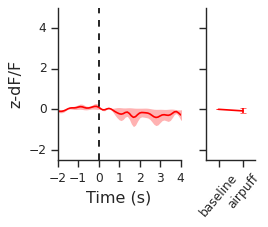

In [ ]:
apt.plotMeans('LHA-LHb','airpuff',
              plot_type='mean and SEM',
              ylim=[-2.5,5],yticks=[-2,0,2,4],xlim=[-2,4],
              color='red',periods=['baseline','airpuff'])
plt.show()

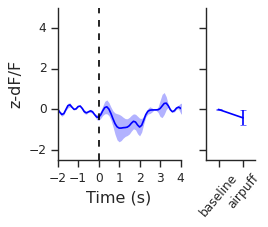

In [ ]:
apt.plotMeans('LHA-VTA','airpuff',
              plot_type='mean and SEM',
              ylim=[-2.5,5],yticks=[-2,0,2,4],xlim=[-2,4],
              color='blue',periods=['baseline','airpuff'])
plt.show()

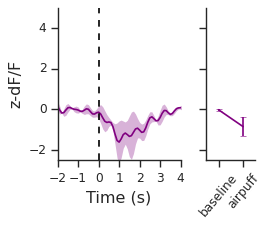

In [ ]:
apt.plotMeans('LHA-DRN','airpuff',
              plot_type='mean and SEM',
              ylim=[-2.5,5],yticks=[-2,0,2,4],xlim=[-2,4],
              color='purple',periods=['baseline','airpuff'])
plt.show()

#### SCT


In [ ]:
sct = FiberPhotometryTest(filename,'SCT')

Experiment information for test SCT is successfully loaded.


In [ ]:
sct.getMeans(auc_frames={'consumption-onset': [[-2,-1],[-0.5,1],[2,4]],
                        'consumption-offset': [[-3,-1],[1,3]]})

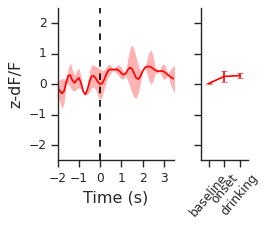

In [ ]:
sct.plotMeans('LHA-LHb','consumption','onset',
              plot_type='mean and SEM',
              ylim=[-2.5,2.5],yticks=[-2,-1,0,1,2],xlim=[-2,3.5],
              color='red',periods=['baseline','onset','drinking'])
plt.show()

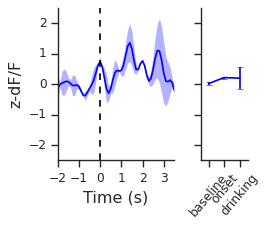

In [ ]:
sct.plotMeans('LHA-VTA','consumption','onset',
              plot_type='mean and SEM',
              ylim=[-2.5,2.5],yticks=[-2,-1,0,1,2],xlim=[-2,3.5],
              color='blue',periods=['baseline','onset','drinking'])
plt.show()

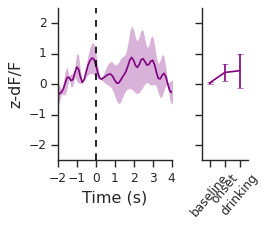

In [ ]:
sct.plotMeans('LHA-DRN','consumption','onset',
              plot_type='mean and SEM',
              ylim=[-2.5,2.5],yticks=[-2,-1,0,1,2],xlim=[-2,4],
              color='purple',periods=['baseline','onset','drinking'])
plt.show()

#### OFT

In [ ]:
oft = FiberPhotometryTest(filename,'OFT')

Experiment information for test OFT is successfully loaded.


In [ ]:
oft.getMeans(auc_frames = {'immobility-onset': [[-3,-1],[1,3]],
                          'immobility-offset': [[-3,-1],[-1,0],[0,1],[1,3]]})

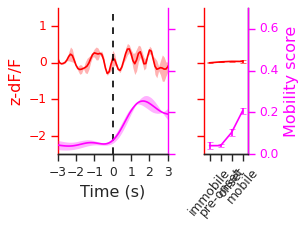

In [ ]:
oft.plotMeans('LHA-LHb','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='red',periods=['immobile','pre-onset','onset','mobile'],
              figsize=(4,3),save=True)
plt.show()

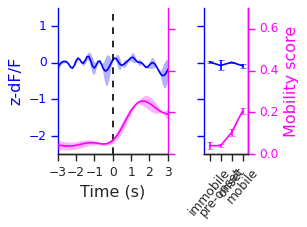

In [ ]:
oft.plotMeans('LHA-VTA','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='blue',periods=['immobile','pre-onset','onset','mobile'],
              figsize=(4,3),save=True)
plt.show()

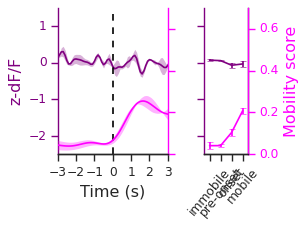

In [ ]:
oft.plotMeans('LHA-DRN','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='purple',periods=['immobile','pre-onset','onset','mobile'],
              figsize=(4,3),save=True)
plt.show()

#### TST

In [ ]:
tst = FiberPhotometryTest(filename,'TST')

Experiment information for test TST is successfully loaded.


In [ ]:
tst.getMeans(auc_frames={'immobility-onset': [[-3,-1],[1,3]],
                        'immobility-offset': [[-3,-1],[-1,0],[0,1],[1,3]]})

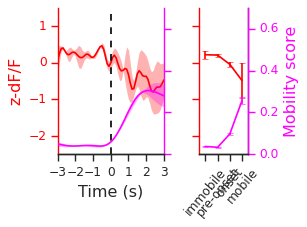

In [ ]:
tst.plotMeans('LHA-LHb','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='red',periods=['immobile','pre-onset','onset','mobile'],
              subplot_ratio=[5,2.3],figsize=(4,3),save=True)
plt.show()

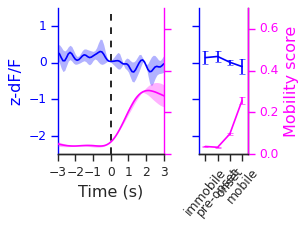

In [ ]:
 tst.plotMeans('LHA-VTA','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='blue',periods=['immobile','pre-onset','onset','mobile'],
              subplot_ratio=[5,2.3],figsize=(4,3),save=True)
plt.show()

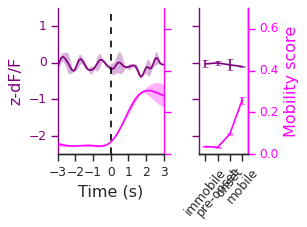

In [ ]:
tst.plotMeans('LHA-DRN','immobility','offset',measure='movement',
              plot_type='mean and SEM',
              ylim=[-2.5,1.5],yticks=[-2,-1,0,1],xlim=[-3,3],
              ylim1=[0,0.7],yticks1=[0,0.2,0.4,0.6],
              color='purple',periods=['immobile','pre-onset','onset','mobile'],
              subplot_ratio=[5,2.3],figsize=(4,3),save=True)
plt.show()

# Example trace

In [ ]:
r = FiberPhotometryRecording()
r.loadRecording(filename,'LHA63','APT','1')

The recording for mouse LHA63 in the experiment APT-1 is successfully loaded.


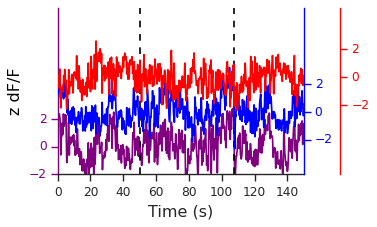

In [ ]:
r.plotExample(['LHA-DRN','LHA-VTA','LHA-LHb'],event='airpuff',
              t0=130,t1=280,
              ylim=[-2,10],ylim1=[-4.5,7.5],ylim2=[-7,5],
              yticks=[-2,0,2],yticks1=[-2,0,2],yticks2=[-2,0,2],
              figsize=(5,3))
plt.show()

In [ ]:
r = FiberPhotometryRecording()
r.loadRecording(filename,'LHA63','SCT','1')

The recording for mouse LHA63 in the experiment SCT-1 is successfully loaded.


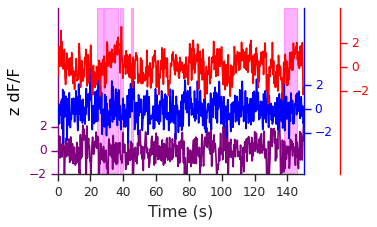

In [ ]:
r.plotExample(['LHA-DRN','LHA-VTA','LHA-LHb'],'consumption',
              t0=30,t1=180,
              ylim=[-2,12],ylim1=[-5.5,8.5],ylim2=[-9,5],
              yticks=[-2,0,2],yticks1=[-2,0,2],yticks2=[-2,0,2],
              figsize=(5,3))
plt.show()

In [ ]:
r = FiberPhotometryRecording()
r.loadRecording(filename,'LHA63','OFT','1')

The recording for mouse LHA63 in the experiment OFT-1 is successfully loaded.


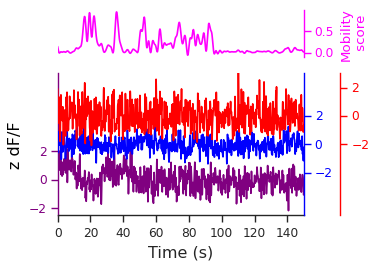

In [ ]:
r.plotExample(['LHA-DRN','LHA-VTA','LHA-LHb'],measure='movement',
              t0=296,t1=446,
              ylim=[-2.5,7.5],ylim1=[-5,5],ylim2=[-7,3],
              yticks=[-2,0,2],yticks1=[-2,0,2],yticks2=[-2,0,2],
              ylim_m=[-0.1,1],yticks_m=[0,0.5],
              figsize=(5,3.5))
plt.show()

In [ ]:
r = FiberPhotometryRecording()
r.loadRecording(filename,'LHA63','TST','1')

The recording for mouse LHA63 in the experiment TST-1 is successfully loaded.


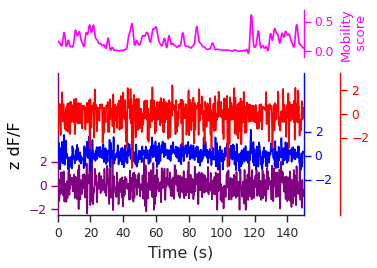

In [ ]:
r.plotExample(['LHA-DRN','LHA-VTA','LHA-LHb'],measure='movement',
              t0=300,t1=450,
              ylim=[-2.5,9.5],ylim1=[-5,7],ylim2=[-8.5,3.5],
              yticks=[-2,0,2],yticks1=[-2,0,2],yticks2=[-2,0,2],
              ylim_m=[-0.1,0.7],yticks_m=[0,0.5],
              figsize=(5,3.5))
plt.show()

# Total correlation between signals of LH outputs

In [ ]:
apt = FiberPhotometryTest(filename,'APT')
apt.getOutputCorrelation('LHA-DRN','LHA-VTA')
apt.getOutputCorrelation('LHA-DRN','LHA-LHb')
apt.getOutputCorrelation('LHA-VTA','LHA-LHb')

In [ ]:
sct = FiberPhotometryTest(filename,'SCT')
sct.getOutputCorrelation('LHA-DRN','LHA-VTA')
sct.getOutputCorrelation('LHA-DRN','LHA-LHb')
sct.getOutputCorrelation('LHA-VTA','LHA-LHb')

In [ ]:
oft = FiberPhotometryTest(filename,'OFT')
oft.getOutputCorrelation('LHA-DRN','LHA-VTA')
oft.getOutputCorrelation('LHA-DRN','LHA-LHb')
oft.getOutputCorrelation('LHA-VTA','LHA-LHb')

In [ ]:
tst = FiberPhotometryTest(filename,'TST')
tst.getOutputCorrelation('LHA-DRN','LHA-VTA')
tst.getOutputCorrelation('LHA-DRN','LHA-LHb')
tst.getOutputCorrelation('LHA-VTA','LHA-LHb')

In [ ]:
exp = FiberPhotometryExperiment(filename)

Tests information is successfully loaded.


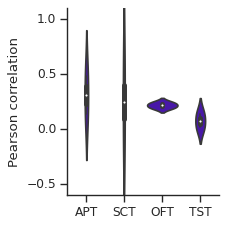

In [ ]:
exp.plotRoverTests('LHA-DRN',output1='LHA-VTA',tests=['APT','SCT','OFT','TST'],
                 ylabel='Pearson correlation',ylim=[-0.6,1.1],yticks=[-0.5,0,0.5,1],color=(0.25,0,0.75))
plt.show()

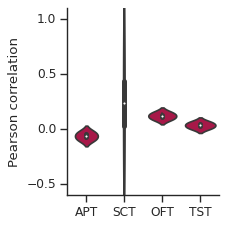

In [ ]:
exp.plotRoverTests('LHA-DRN',output1='LHA-LHb',tests=['APT','SCT','OFT','TST'],
                 ylabel='Pearson correlation',ylim=[-0.6,1.1],yticks=[-0.5,0,0.5,1],color=(0.75,0,0.25))
plt.show()

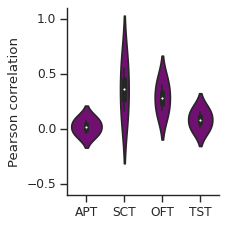

In [ ]:
exp.plotRoverTests('LHA-VTA',output1='LHA-LHb',tests=['APT','SCT','OFT','TST'],
                 ylabel='Pearson correlation',ylim=[-0.6,1.1],yticks=[-0.5,0,0.5,1],color=(0.5,0,0.5))
plt.show()

# Total correlation between mobility score and signal of LH outputs

In [ ]:
oft = FiberPhotometryTest(filename,'OFT')

Experiment information for test OFT is successfully loaded.


In [ ]:
oft.getMeasureCorrelation('movement')

In [ ]:
tst = FiberPhotometryTest(filename,'TST')

Experiment information for test TST is successfully loaded.


In [ ]:
tst.getMeasureCorrelation('movement')

In [ ]:
exp = FiberPhotometryExperiment(filename)

Tests information is successfully loaded.


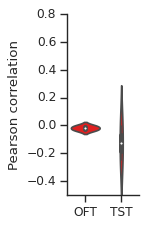

In [ ]:
exp.plotRoverTests('LHA-LHb',measure='movement',tests=['OFT','TST'],
                 color='red',ylabel='Pearson correlation',ylim=[-0.5,0.8],figsize=(2,3))
plt.show()

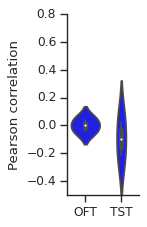

In [ ]:
exp.plotRoverTests('LHA-VTA',measure='movement',tests=['OFT','TST'],
                 color='blue',ylabel='Pearson correlation',ylim=[-0.5,0.8],figsize=(2,3))
plt.show()

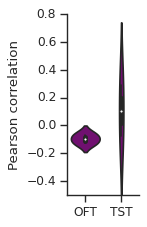

In [ ]:
exp.plotRoverTests('LHA-DRN',measure='movement',tests=['OFT','TST'],
                 color='purple',ylabel='Pearson correlation',ylim=[-0.5,0.8],figsize=(2,3))
plt.show()

# Perievent correlation between mobility score and signal of LH outputs

#### OFT

In [ ]:
oft = FiberPhotometryTest(filename,'OFT')

Experiment information for test OFT is successfully loaded.


In [ ]:
oft.getMeasurePerieventCorrelation('immobility','movement',win=3)

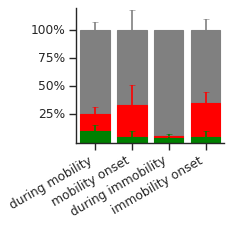

In [ ]:
oft.plotMeasureCorrelationCounts('movement','LHA-DRN','immobility',
                                   event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

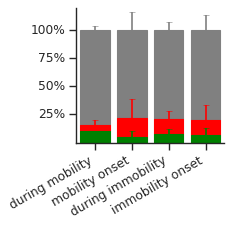

In [ ]:
oft.plotMeasureCorrelationCounts('movement','LHA-VTA','immobility',
                                   event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

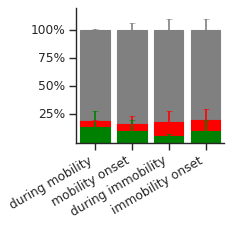

In [ ]:
oft.plotMeasureCorrelationCounts('movement','LHA-LHb','immobility',
                                   event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

#### TST

In [ ]:
tst = FiberPhotometryTest(filename,'TST')

Experiment information for test TST is successfully loaded.


In [ ]:
tst.getMeasurePerieventCorrelation('immobility','movement',win=3)

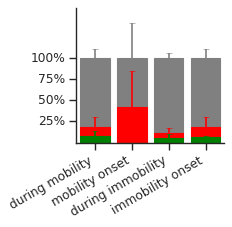

In [ ]:
tst.plotMeasureCorrelationCounts('movement','LHA-LHb','immobility',
                                  event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

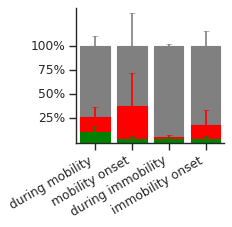

In [ ]:
tst.plotMeasureCorrelationCounts('movement','LHA-VTA','immobility',
                                   event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

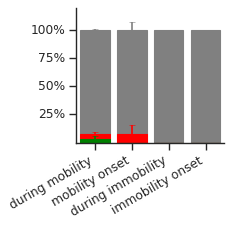

In [ ]:
tst.plotMeasureCorrelationCounts('movement','LHA-DRN','immobility',
                                  event_labels = ['during mobility','mobility onset','during immobility','immobility onset'])
plt.show()

# Save summary data to excel file for statistical analysis

In [ ]:
apt = FiberPhotometryTest(filename,'APT')
sct = FiberPhotometryTest(filename,'SCT')
oft = FiberPhotometryTest(filename,'OFT')
tst = FiberPhotometryTest(filename,'TST')

Experiment information for test APT is successfully loaded.
Experiment information for test SCT is successfully loaded.
Experiment information for test OFT is successfully loaded.
Experiment information for test TST is successfully loaded.


In [ ]:
df_apt = apt.getDataFrameAUC('airpuff','onset',['baseline','airpuff'])
df_sct = sct.getDataFrameAUC('consumption','onset',['baseline','onset','drinking'])
df_oft = oft.getDataFrameAUC('immobility','offset',['immobile','preonset','onset','mobile'])
df_tst = tst.getDataFrameAUC('immobility','offset',['immobile','preonset','onset','mobile'])
df_oft_mob = oft.getDataFrameAUCmeasure('immobility','offset',['immobile','preonset','onset','mobile'])
df_tst_mob = tst.getDataFrameAUCmeasure('immobility','offset',['immobile','preonset','onset','mobile'])

In [ ]:
exp = FiberPhotometryExperiment(filename)

Tests information is successfully loaded.


In [ ]:
df_corr = exp.getDataFrameRoutputs(tests=['APT','SCT','OFT','TST'])

In [ ]:
!pip install xlsxwriter
import xlsxwriter

In [ ]:
writer = pd.ExcelWriter('../sourcedata/fig1-supp1_LH-eYFP.xlsx', engine='xlsxwriter')
df_apt.to_excel(writer,sheet_name='APT', index=False)
df_sct.to_excel(writer,sheet_name='SCT', index=False)
df_oft.to_excel(writer,sheet_name='OFT', index=False)
df_tst.to_excel(writer,sheet_name="TST", index=False)
df_oft_mob.to_excel(writer,sheet_name='OFT_mobileScore', index=False)
df_tst_mob.to_excel(writer,sheet_name="TST_mobileScore", index=False)
df_corr.to_excel(writer,sheet_name='outputCorrelation', index=False)
writer.save()

In [ ]:
df_total = exp.getDataFrameRmeasure('movement', ['OFT','TST'])
df_peri = exp.getDataFrameMeasureCorrCounts('movement',['OFT','TST'])

In [ ]:
writer = pd.ExcelWriter('../sourcedata/fig2-supp1_LH-eYFP_movementCorrelation.xlsx', engine='xlsxwriter')
df_total.to_excel(writer,sheet_name='total',index=False)
df_peri.to_excel(writer,sheet_name='perievent',index=False)
writer.save()

In [ ]:
df_peri

,mouse,test,output,event,pos-corr,neg-corr,not-corr
0,LHA62,OFT,LHA-LHb,immobility_off-on,0.280000,0.040000,0.680000
1,LHA63,OFT,LHA-LHb,immobility_off-on,0.000000,0.060000,0.940000
2,LHA62,OFT,LHA-LHb,immobility_offset,0.200000,0.133333,0.666667
3,LHA63,OFT,LHA-LHb,immobility_offset,0.000000,0.000000,1.000000
4,LHA62,OFT,LHA-LHb,immobility_on-off,0.080000,0.220000,0.700000
5,LHA63,OFT,LHA-LHb,immobility_on-off,0.040000,0.020000,0.940000
6,LHA62,OFT,LHA-LHb,immobility_onset,0.200000,0.200000,0.600000
7,LHA63,OFT,LHA-LHb,immobility_onset,0.000000,0.000000,1.000000
8,LHA62,OFT,LHA-VTA,immobility_off-on,0.100000,0.100000,0.800000
9,LHA63,OFT,LHA-VTA,immobility_off-on,0.100000,0.020000,0.880000
